In [1]:
# %matplotlib widget
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import spikeinterface as si
from trimesh import load_mesh
import k3d
import matplotlib.cm as cm
%matplotlib inline


In [2]:
# pip install k3d

In [3]:

def make_ccf_tbl(animal_id, annotator = 'zs', data_type = 'curated', save_to_session = True):
    annotation_dir = f'/root/capsule/data/alignment_{annotator}/{animal_id}'
    if os.path.exists(annotation_dir) == False:
        print('No annotation directory found')

    # grab all session ids for this animal
    session_list_annotation = os.listdir(annotation_dir)
    date_list_annotation = [parseSessionID(session)[1] for session in session_list_annotation]
    session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
    session_list_all = session_assets['session_id']
    session_list_animal = [session for session in session_list_all if isinstance(session, str)]
    session_list_animal = [session for session in session_list_animal if animal_id in session]
    date_list_animal = [parseSessionID(session)[1] for session in session_list_animal]

    # for each date_list, find the corresponding session in session_list_all within 1 minute tolerance
    session_list = []
    for date in date_list_annotation:
        time_diff = [abs((date_list_animal_curr - date).total_seconds()) for date_list_animal_curr in date_list_animal]
        min_ind = np.argmin(time_diff)
        if time_diff[min_ind] < 60:
            session_list.append(session_list_animal[min_ind])
        else:
            session_list.append(None)
    
    unit_tbls = []
    probe_tbls = []
    for session_ind in range(len(session_list)):
        if session_list[session_ind] is None:
            print(f'No matching session found for {session_list_annotation[session_ind]}')
            unit_tbls.append(None)
            probe_tbls.append(None)    
        else:
            print(f'Processing {session_list_annotation[session_ind]} matched to {session_list[session_ind]}')
            session = session_list[session_ind]
            session_annotation = session_list_annotation[session_ind]
            session_dir = session_dirs(session_id=session)
            sorting_analyzer = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)
            channel_locations = sorting_analyzer.get_channel_locations()
            unit_locations = sorting_analyzer.get_extension("unit_locations").get_data()
            channel_ids = sorting_analyzer.channel_ids
            channel_num = [int(chan[2:]) for chan in channel_ids]
            unit_loc_along_probe = unit_locations[:, 1]
            channel_loc_along_probe = channel_locations[:, 1]
            ccf_location_file = os.path.join(annotation_dir, session_annotation, 'ProbeA/ccf_channel_locations.json')
            ccf_dict = json.load(open(ccf_location_file, 'r'))
            ccf_df = pd.DataFrame(ccf_dict).T
            ccf_df.index = ccf_df.index.astype(str)  # make sure index is string
            ccf_df["channel_ind"] = ccf_df.index.str.split("_").str[1].astype(int)
            # filter by if channel_ind in channel_num
            ccf_df = ccf_df[ccf_df["channel_ind"].isin(channel_num)]
            ccf_df["loc_along_probe"] = channel_loc_along_probe
            # x for ml, y for ap, z for dv, with ccf origin and scale of mm
            xp = pd.to_numeric(ccf_df['loc_along_probe'], errors='raise').to_numpy()
            fp_x = pd.to_numeric(ccf_df['x'], errors='raise').to_numpy()
            fp_y = pd.to_numeric(ccf_df['y'], errors='raise').to_numpy()
            fp_z = pd.to_numeric(ccf_df['z'], errors='raise').to_numpy()

            unit_x_ccf = np.interp(unit_loc_along_probe, xp, fp_x)
            unit_y_ccf = np.interp(unit_loc_along_probe, xp, fp_y)
            unit_z_ccf = np.interp(unit_loc_along_probe, xp, fp_z)
            unit_ccf_df = pd.DataFrame({'unit_id': sorting_analyzer.unit_ids,
                                    'x_ccf': unit_x_ccf,
                                    'y_ccf': unit_y_ccf,
                                    'z_ccf': unit_z_ccf,
                                    'loc_along_probe': unit_loc_along_probe})
            unit_tbl = get_unit_tbl(session, data_type)
            unit_tbl = unit_tbl.drop(columns=['x_ccf', 'y_ccf', 'z_ccf'], errors="ignore")
            if save_to_session:
                save_dir = os.path.join(session_dir[f'ephys_processed_dir_{data_type}'],'ccf_unit_locations.csv')
                unit_ccf_df.to_csv(save_dir, index=False)
            unit_tbl_combined = unit_tbl.merge(unit_ccf_df, left_on='unit_id', right_on='unit_id', how='left')
            corr = unit_tbl_combined['corr_max_p'].values
            corr[np.isnan(corr)] = 1
            unit_tbl_combined = unit_tbl_combined[(unit_tbl_combined['decoder_label']!='noise') & (unit_tbl_combined['decoder_label']!='artifact') & (corr>0.9)]
            probe_tbls.append(ccf_df)
            unit_tbls.append(unit_tbl_combined)



    norm = Normalize(vmin=0, vmax=1)
    ml, ap, dv = 2, 0, 1
    planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
    mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
    mesh_vertices = np.array(mesh.vertices)
    mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
    # add the other side
    mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
    mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
    mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches
    for plane, ax in zip(planes.keys(), axes):
        # Plot the mesh
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='gray', alpha=0.5, s=0.005,
            edgecolors=None
        )

        # Plot the points
        for session_ind, session in enumerate(session_list):
            unit_tbl_combined = unit_tbls[session_ind]
            unit_tbl_combined = unit_tbl_combined.sort_values(by="p_max", ascending=True)
            x_ccf = -unit_tbl_combined['x_ccf'].values / 25 * 1000
            y_ccf = unit_tbl_combined['y_ccf'].values / 25 * 1000
            z_ccf = -unit_tbl_combined['z_ccf'].values / 25 * 1000
            ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
            ccfs = ccf_pts_convert_to_mm(ccfs)

            # for probe
            x_ccf_probe = -probe_tbls[session_ind]['x'].values / 25 * 1000
            y_ccf_probe = probe_tbls[session_ind]['y'].values / 25 * 1000
            z_ccf_probe = -probe_tbls[session_ind]['z'].values / 25 * 1000
            ccfs_probe = np.column_stack((y_ccf_probe, z_ccf_probe, x_ccf_probe))
            ccfs_probe = ccf_pts_convert_to_mm(ccfs_probe)
            sc = ax.scatter(
                ccfs_probe[:, planes[plane][0]], 
                ccfs_probe[:, planes[plane][1]], 
                color='k', 
                s=5, 
                edgecolors=None,
                linewidth=0.2
                )
            sc = ax.scatter(
                ccfs[:, planes[plane][0]],
                ccfs[:, planes[plane][1]],
                c=unit_tbl_combined['p_max'],
                cmap=colormaps[session_ind],
                s=50, alpha=0.3,
                edgecolors=None, linewidths=1,
            )
            sort_ind = np.argsort(ccfs[:, dv])
            
            # ax.plot(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], color=cm.get_cmap(colormaps[session_ind])(1.0), label=session, linewidth=0.5)

        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

    # add the legend with brightest color for each session

    legend_handles = []
    for session_ind, session in enumerate(session_list):
        cmap = cm.get_cmap(colormaps[session_ind])
        brightest = cmap(1.0)  # lowest value = brightest in Reds/Greens/Blues
        patch = mpatches.Patch(color=brightest, label=session)
        legend_handles.append(patch)

    axes[1].legend(handles=legend_handles, title="Sessions")


    axes[0].invert_yaxis()
    axes[0].invert_xaxis()
    axes[2].invert_yaxis()


    plt.suptitle(f'{animal_id} units in CCF space with max(P(spike|laser)) color coding')
    plt.tight_layout()
    plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_opto_tag.png', dpi=300)


    ml, ap, dv = 2, 0, 1  # axes mapping
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    # --- Load and preprocess mesh ---
    mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
    mesh_vertices = np.array(mesh.vertices)
    mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)

    # Add flipped side
    mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
    mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
    mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])

    # Convert mesh to k3d mesh
    vertices = mesh_vertices_mm.astype(np.float32)
    indices = np.array(mesh.faces, dtype=np.uint32)

    plot = k3d.plot(camera_auto_fit=True)

    plt_mesh = k3d.mesh(
        vertices=vertices,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_right'
    )

    vertices_flipped = vertices.copy()
    vertices_flipped[:, ml] = -vertices_flipped[:, ml]

    plt_mesh_flipped = k3d.mesh(
        vertices=vertices_flipped,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_left'
    )

    plot += plt_mesh
    plot += plt_mesh_flipped

    # --- Add probes + units for each session ---
    for session_ind, session in enumerate(session_list):
        unit_tbl_combined = unit_tbls[session_ind].sort_values(by="p_max", ascending=True)

        # Units
        x_ccf = -unit_tbl_combined['x_ccf'].values / 25 * 1000
        y_ccf = unit_tbl_combined['y_ccf'].values / 25 * 1000
        z_ccf = -unit_tbl_combined['z_ccf'].values / 25 * 1000
        ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
        ccfs = ccf_pts_convert_to_mm(ccfs)

        # Probes
        x_ccf_probe = -probe_tbls[session_ind]['x'].values / 25 * 1000
        y_ccf_probe = probe_tbls[session_ind]['y'].values / 25 * 1000
        z_ccf_probe = -probe_tbls[session_ind]['z'].values / 25 * 1000
        ccfs_probe = np.column_stack((y_ccf_probe, z_ccf_probe, x_ccf_probe))
        ccfs_probe = ccf_pts_convert_to_mm(ccfs_probe)

        # Colormap based on p_max
        cmap = cm.get_cmap(colormaps[session_ind])
        colors = (cmap(unit_tbl_combined['p_max'].values)[:, :3] * 255).astype(np.uint32)
        colors = (colors[:,0] << 16) + (colors[:,1] << 8) + colors[:,2]

        # Units
        plt_units = k3d.points(
            positions=ccfs.astype(np.float32),
            point_size=0.1,
            colors=colors,
            opacity=0.4,
            shader="3d",
            name=f'Units_{session[9:]}'
        )
        plot += plt_units

        # Probes (black points)
        plt_probes = k3d.points(
            positions=ccfs_probe.astype(np.float32),
            point_size=0.02,
            color=0x000000,
            shader="3d",
            name=f'Probe_{session[9:]}'
        )
        plot += plt_probes
    # save a html file
    # --- Save interactive plot to HTML ---
    html_file = f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_plot.html'
    with open(html_file, 'w') as f:
        f.write(plot.get_snapshot())

    plot.display()

Processing behavior_785956_2025-05-20_14-15-13 matched to behavior_785956_2025-05-20_14-15-19
Single experiment found: experiment1, recording1
Single experiment found: experiment1, recording1
Processing behavior_785956_2025-05-23_13-45-17 matched to behavior_785956_2025-05-23_13-45-21
Single experiment found: experiment1, recording1
Single experiment found: experiment1, recording1
Processing behavior_785956_2025-05-21_13-41-59 matched to behavior_785956_2025-05-21_13-42-02
Single experiment found: experiment1, recording1
Single experiment found: experiment1, recording1


/tmp/ipykernel_551288/2267298641.py:148: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_551288/2267298641.py:228: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])


Output()

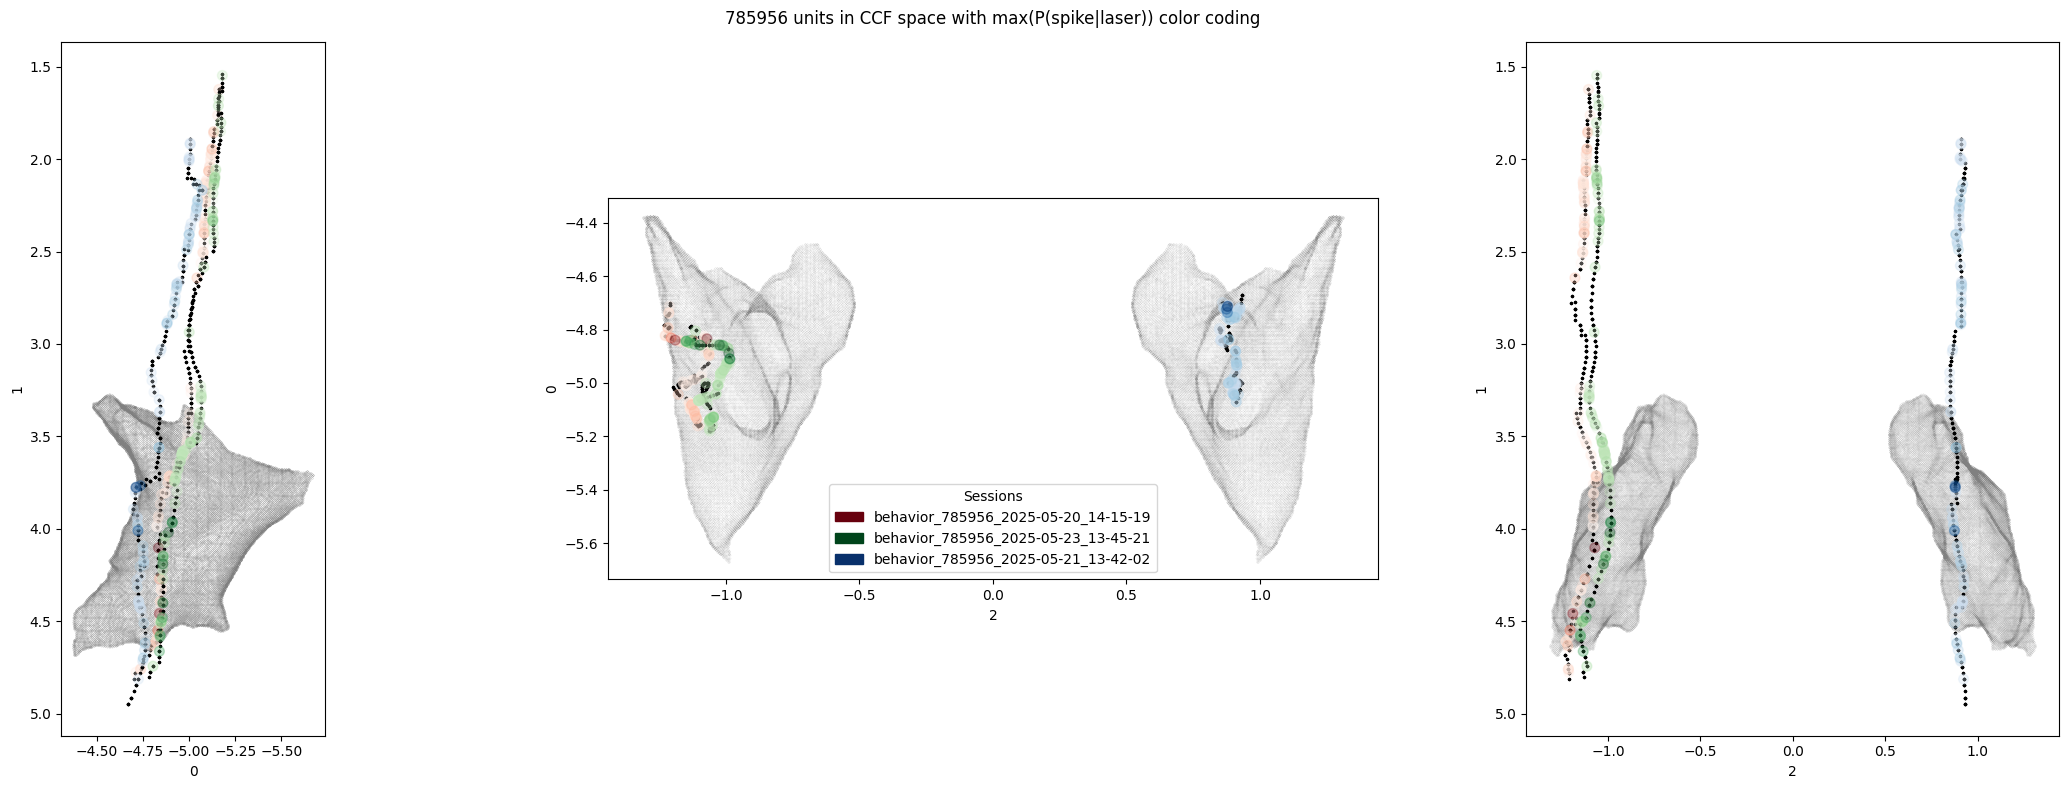

In [7]:
make_ccf_tbl('785956', annotator='zs', data_type='curated', save_to_session=True)